In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.optim as optim
from torchvision import datasets
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
use_gpu = torch.cuda.is_available()

# Model Design


Some tips you can use in the model design:

*   Convolution
*   Linear
*   Pooling
*   Batch normalization
*   RELU
*   Dropout




In [167]:
import torch
import torch.nn as nn

class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        ### TODO : You can design the model architechture ###

        self.conv1 = nn.Conv2d(in_channels= 3 , out_channels=32, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels= 32 , out_channels=32, kernel_size=3, stride=1, padding=1, bias= False)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv3 = nn.Conv2d(in_channels= 32 , out_channels=64, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn2 = nn.BatchNorm2d(64) 
        self.conv4 = nn.Conv2d(in_channels=64 , out_channels=64, kernel_size=3, stride=1, padding=1, bias= False)
        self.conv5 = nn.Conv2d(in_channels=64 , out_channels=128, kernel_size=3, stride=1, padding=1, bias= False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128 , out_channels=128, kernel_size=3, stride=1, padding=1, bias= False)
        self.dropout1 = nn.Dropout(0.3)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(8192,4096)
        self.bn4 = nn.BatchNorm1d(4096)
        self.linear2 = nn.Linear(4096,1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.linear3 = nn.Linear(1024,256)
        self.bn6 = nn.BatchNorm1d(256)
        self.linear4 = nn.Linear(256,32)
        self.bn7 = nn.BatchNorm1d(32)
        self.linear5 = nn.Linear(32,10)

         ######################################################
    def forward(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        
        x = self.linear1(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.dropout1(x)

        x = self.linear2(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.dropout1(x)

        x = self.linear3(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.dropout1(x)

        x = self.linear4(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout1(x)
        x = self.linear5(x)
        
        

        return x




In [168]:
# Create an instance of the DNN model
net = DNN().cuda()  # Move the model to GPU if available

# Caculating the number of the parameter and the MACs of the model

In [169]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
grad_para = count_parameters(net)
# print(f'Total params: {grad_para / 1e6}M')
summary(net,(3,32,32))

#Compute MACs
from thop import profile
input1 = torch.randn(1,3,32,32).cuda()
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,432
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]          36,864
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,728
      BatchNorm2d-14            [-1, 12

# Configuration

In [170]:
### You can modify the configuration for model training ###

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = optim.Adam(net.parameters(), lr=0.001)

# The number of batch size.
batch_size = 128

# If no improvement in 'patience' epochs, early stop.
patience  = 10

# The number of training epochs
n_epoch = 200

_exp_name = "N26122246_cifar10"

# Dataloader

In [171]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data",train= True, download=True,   transform = transform)

test_data = datasets.CIFAR10("data",  train= False, download=True, transform = transform)

# # Number of subprocesses to use for data loading
# num_workers = 0

# Percentage of training set to use as validation
n_valid = 0.2

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)

split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


Files already downloaded and verified
Files already downloaded and verified


In [172]:
# Training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  sampler = train_sampler , num_workers=2)

# Validation data
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler, num_workers = 2)

# Test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Model Training

In [173]:
train_loss_epoch = []
train_acc_epoch = []
val_loss_epoch = []
val_acc_epoch = []
best_acc = 0
epoch_counter = 0

for epoch in range(n_epoch):  # loop over the dataset multiple times


    running_loss = 0.0
    epoch_counter += 1

    ################## Training ##################
    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(),labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (outputs.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)

    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    train_loss_epoch.append(train_loss)
    train_acc_epoch.append(train_acc)

    # Print the information.
    print('========================================================================================================')
    print(f"[ Train | {epoch + 1:03d}/{n_epoch:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    ################## Validition ##################
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for data in tqdm(validloader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = data
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = net(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    val_loss_epoch.append(valid_loss)


    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epoch:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


     # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(net.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

print('Finished Training')

[ Train | 001/200 ] loss = 1.50662, acc = 0.46423


100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


[ Valid | 001/200 ] loss = 1.20663, acc = 0.58821
Best model found at epoch 0, saving model
[ Train | 002/200 ] loss = 1.07575, acc = 0.63508


100%|██████████| 79/79 [00:05<00:00, 14.63it/s]


[ Valid | 002/200 ] loss = 0.99794, acc = 0.66525
Best model found at epoch 1, saving model
[ Train | 003/200 ] loss = 0.88038, acc = 0.70687


100%|██████████| 79/79 [00:05<00:00, 13.96it/s]


[ Valid | 003/200 ] loss = 0.86294, acc = 0.71331
Best model found at epoch 2, saving model
[ Train | 004/200 ] loss = 0.75930, acc = 0.74875


100%|██████████| 79/79 [00:05<00:00, 14.17it/s]


[ Valid | 004/200 ] loss = 0.81248, acc = 0.73803
Best model found at epoch 3, saving model
[ Train | 005/200 ] loss = 0.66277, acc = 0.78150


100%|██████████| 79/79 [00:05<00:00, 14.18it/s]


[ Valid | 005/200 ] loss = 0.77747, acc = 0.74506
Best model found at epoch 4, saving model
[ Train | 006/200 ] loss = 0.59134, acc = 0.80756


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


[ Valid | 006/200 ] loss = 0.75643, acc = 0.76078
Best model found at epoch 5, saving model
[ Train | 007/200 ] loss = 0.56265, acc = 0.81757


100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


[ Valid | 007/200 ] loss = 0.73694, acc = 0.76295
Best model found at epoch 6, saving model
[ Train | 008/200 ] loss = 0.52715, acc = 0.83144


100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


[ Valid | 008/200 ] loss = 0.76670, acc = 0.75811
[ Train | 009/200 ] loss = 0.44659, acc = 0.85700


100%|██████████| 79/79 [00:05<00:00, 14.21it/s]


[ Valid | 009/200 ] loss = 0.74698, acc = 0.76810
Best model found at epoch 8, saving model
[ Train | 010/200 ] loss = 0.44366, acc = 0.85531


100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


[ Valid | 010/200 ] loss = 0.83237, acc = 0.73991
[ Train | 011/200 ] loss = 0.41799, acc = 0.86569


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


[ Valid | 011/200 ] loss = 0.85935, acc = 0.74733
[ Train | 012/200 ] loss = 0.34509, acc = 0.89015


100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


[ Valid | 012/200 ] loss = 0.80444, acc = 0.76582
[ Train | 013/200 ] loss = 0.29570, acc = 0.90500


100%|██████████| 79/79 [00:05<00:00, 14.28it/s]


[ Valid | 013/200 ] loss = 0.82152, acc = 0.76820
Best model found at epoch 12, saving model
[ Train | 014/200 ] loss = 0.26301, acc = 0.91666


100%|██████████| 79/79 [00:05<00:00, 14.19it/s]


[ Valid | 014/200 ] loss = 0.85061, acc = 0.76305
[ Train | 015/200 ] loss = 0.29345, acc = 0.90618


100%|██████████| 79/79 [00:05<00:00, 14.40it/s]


[ Valid | 015/200 ] loss = 0.83801, acc = 0.76830
Best model found at epoch 14, saving model
[ Train | 016/200 ] loss = 0.23266, acc = 0.92492


100%|██████████| 79/79 [00:05<00:00, 14.22it/s]


[ Valid | 016/200 ] loss = 0.86131, acc = 0.76760
[ Train | 017/200 ] loss = 0.21598, acc = 0.93014


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


[ Valid | 017/200 ] loss = 0.89729, acc = 0.76998
Best model found at epoch 16, saving model
[ Train | 018/200 ] loss = 0.25907, acc = 0.91628


100%|██████████| 79/79 [00:05<00:00, 14.19it/s]


[ Valid | 018/200 ] loss = 0.98293, acc = 0.74733
[ Train | 019/200 ] loss = 0.23536, acc = 0.92482


100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


[ Valid | 019/200 ] loss = 0.93570, acc = 0.75376
[ Train | 020/200 ] loss = 0.17952, acc = 0.94242


100%|██████████| 79/79 [00:05<00:00, 14.37it/s]


[ Valid | 020/200 ] loss = 0.90750, acc = 0.77482
Best model found at epoch 19, saving model
[ Train | 021/200 ] loss = 0.11924, acc = 0.96131


100%|██████████| 79/79 [00:05<00:00, 14.38it/s]


[ Valid | 021/200 ] loss = 0.96922, acc = 0.77878
Best model found at epoch 20, saving model
[ Train | 022/200 ] loss = 0.11387, acc = 0.96306


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


[ Valid | 022/200 ] loss = 0.98291, acc = 0.77502
[ Train | 023/200 ] loss = 0.10266, acc = 0.96605


100%|██████████| 79/79 [00:05<00:00, 14.15it/s]


[ Valid | 023/200 ] loss = 1.04984, acc = 0.76938
[ Train | 024/200 ] loss = 0.16678, acc = 0.94579


100%|██████████| 79/79 [00:05<00:00, 13.95it/s]


[ Valid | 024/200 ] loss = 0.94525, acc = 0.77087
[ Train | 025/200 ] loss = 0.13334, acc = 0.95659


100%|██████████| 79/79 [00:05<00:00, 14.29it/s]


[ Valid | 025/200 ] loss = 1.01258, acc = 0.76919
[ Train | 026/200 ] loss = 0.11159, acc = 0.96463


100%|██████████| 79/79 [00:05<00:00, 14.16it/s]


[ Valid | 026/200 ] loss = 1.00905, acc = 0.77670
[ Train | 027/200 ] loss = 0.09043, acc = 0.97075


100%|██████████| 79/79 [00:05<00:00, 14.10it/s]


[ Valid | 027/200 ] loss = 1.02939, acc = 0.78085
Best model found at epoch 26, saving model
[ Train | 028/200 ] loss = 0.10664, acc = 0.96660


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


[ Valid | 028/200 ] loss = 1.09220, acc = 0.76691
[ Train | 029/200 ] loss = 0.11293, acc = 0.96453


100%|██████████| 79/79 [00:05<00:00, 13.65it/s]


[ Valid | 029/200 ] loss = 1.05399, acc = 0.76365
[ Train | 030/200 ] loss = 0.17261, acc = 0.94659


100%|██████████| 79/79 [00:05<00:00, 14.19it/s]


[ Valid | 030/200 ] loss = 0.94615, acc = 0.76820
[ Train | 031/200 ] loss = 0.12332, acc = 0.96119


100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


[ Valid | 031/200 ] loss = 1.00858, acc = 0.76493
[ Train | 032/200 ] loss = 0.09840, acc = 0.96750


100%|██████████| 79/79 [00:05<00:00, 14.51it/s]


[ Valid | 032/200 ] loss = 1.04531, acc = 0.78036
[ Train | 033/200 ] loss = 0.08853, acc = 0.97262


100%|██████████| 79/79 [00:05<00:00, 14.50it/s]


[ Valid | 033/200 ] loss = 1.01614, acc = 0.78046
[ Train | 034/200 ] loss = 0.07936, acc = 0.97626


100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


[ Valid | 034/200 ] loss = 1.17120, acc = 0.75425
[ Train | 035/200 ] loss = 0.09021, acc = 0.97110


100%|██████████| 79/79 [00:05<00:00, 14.45it/s]


[ Valid | 035/200 ] loss = 1.08138, acc = 0.77195
[ Train | 036/200 ] loss = 0.15859, acc = 0.95098


100%|██████████| 79/79 [00:05<00:00, 14.58it/s]


[ Valid | 036/200 ] loss = 0.99808, acc = 0.76493
[ Train | 037/200 ] loss = 0.12817, acc = 0.95929


100%|██████████| 79/79 [00:05<00:00, 14.47it/s]


[ Valid | 037/200 ] loss = 1.10071, acc = 0.76058
[ Train | 038/200 ] loss = 0.08478, acc = 0.97287


100%|██████████| 79/79 [00:05<00:00, 14.46it/s]

[ Valid | 038/200 ] loss = 1.04352, acc = 0.77423
No improvment 10 consecutive epochs, early stopping
Finished Training


# Model Testing

Your test accuracy  shoud be greater than 75%

In [174]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        if use_gpu:
            images, labels = images.cuda(),labels.cuda()
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 77 %


# Plot the train/val loss curve

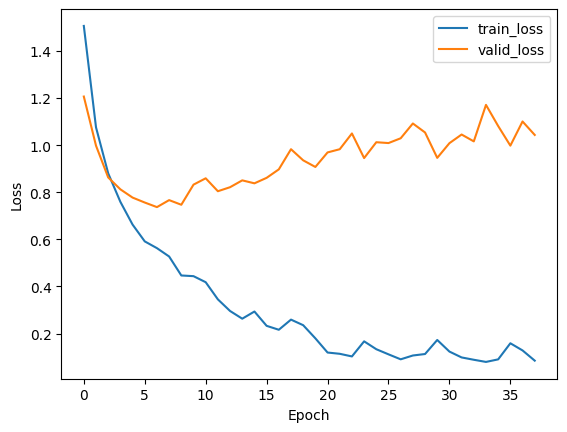

In [175]:
from matplotlib import pyplot as plt
### TODO : Please plot the rain/val loss curve ###


plt.plot(train_loss_epoch, label = 'train_loss')
plt.plot(val_loss_epoch, label = 'valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###########################################################

# Netron

Save the model in .onnx format


# **Saving your model in .onnx format ,download it , and using Netron to visualize the model**

In [176]:
# Some standard imports
import io
import torch.utils.model_zoo as model_zoo
import torch.onnx

trained_net = DNN().cuda()

input_shape = torch.randn(1,3,32,32).cuda()
trained_net_weight = torch.load("N26122246_cifar10_best.ckpt")
trained_net.load_state_dict(trained_net_weight,strict=False)
trained_net.eval()

### TODO : export your model in .onnx format ###
torch.onnx.export( trained_net,
                  input_shape,
                  "N26122246_cifar10.onnx",
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})







*   netron :
  https://netron.app/
  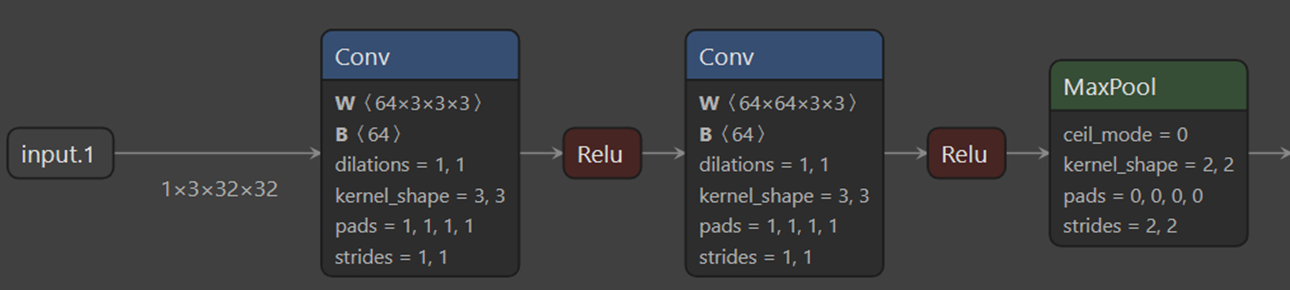